### Dynamic Asset Allocation

Advances in Financial Machine Learning, Chapter.21

In [1]:
from itertools import combinations_with_replacement

def pigoenHole(k, n) :
    """
    k: number of holes
    n: number of pigeons
    """
    for i in combinations_with_replacement(range(n), k):
        r = [0] * n
        for j in i :
            r[j] += 1
        yield r

In [2]:
import numpy as np
from itertools import product

def getAllweights(k ,n) :
    """
    k : size of portfolio
    n : number of assets
    """
    parts, weights = pigoenHole(k, n), None
    for part in parts :
        weight = np.array(part) / float(k)
        for prod in product([-1, 1], repeat = n) :
            weight_signed = (weight * prod).reshape(-1, 1)
            if weights is None :
                weights = weight_signed.copy()
            else :
                weights = np.concatenate((weights, weight_signed), axis = 1)
    return weights

In [15]:
def eval_t_costs(weights, params) :
    tcost = np.zeros(weights.shape[1])
    weight = np.zeros(shape = weights.shape[0])
    for i in range(tcost.shape[0]) :
        cost = params[i]['c']
        tcost[i] = (cost * abs(weights[:, i] - weight) ** 0.5).sum()
        weight = weights[:, i].copy()
    return tcost

def evaluate_sharpe_ratio(params, weights, tcost) :
    mean, cov = 0, 0
    for i in range(weights.shape[1]) :
        params_ = params[i]
        mean += np.dot(weights[:, i].T, params_['mean'])[0] - tcost[i]
        cov += np.dot(weights[:, i].T, np.dot(params_['cov'], weights[:, i]))
    sharpe_ratio = mean / np.sqrt(cov)
    return sharpe_ratio

def dynamic_optimal_portfolio(params, k = None) :
    if k is None :
        k = params[0]['mean'].shape[0]
    n = params[0]['mean'].shape[0]
    weights_all, sharpe_ratio = getAllweights(k, n), None
    for prod_ in product(weights_all.T, repeat = len(params)) :
        weight = np.array(prod_).T
        tcost_ = eval_t_costs(weight, params)
        sharpe_ratio_ = evaluate_sharpe_ratio(params, weight, tcost_) # 궤적 평가
        if sharpe_ratio is None or sharpe_ratio_ > sharpe_ratio :
            sharpe_ratio = sharpe_ratio_
            weights = weight.copy()
    return weights

In [16]:
def random_matrix_with_rank(n_samples, n_cols, rank, sigma = 0, homNoise = True, random_state = 0) :
    rng = np.random.RandomState(random_state)
    U, _, _ = np.linalg.svd(rng.randn(n_cols, n_cols))
    x = np.dot(rng.randn(n_samples, rank), U[:, :rank].T)
    if homNoise :
        x += sigma * rng.randn(n_samples, n_cols) # homoscedastic noise
    else :
        sigmas = sigma * (rng.rand(n_cols) + 0.5) # heteroscedastic noise
        x += rng.randn(n_samples, n_cols) * sigmas
    return x

아래의 코드는 $H$ vector의 평균, 공분산 행렬, 거래 비용 요인 $C, \mu, V$를 생성한다. 이러한 변수들은 params 리스트에 저장된다

In [17]:
def gen_mean(size) :
    # generate mean vector
    rMean = np.random.normal(size = (size, 1))
    return rMean

size, horizon = 3, 2 # size : number of assets, horizon : number of periods
params = []

for h in range(horizon) :
    x = random_matrix_with_rank(1000, size, size, sigma = 0, homNoise = True, random_state = 42)
    mean_, cov_ = gen_mean(size), np.cov(x, rowvar = False)
    c_ = np.random.uniform(size = cov_.shape[0]) * np.sqrt(np.diag(cov_))
    params.append({'mean' : mean_, 'cov' : cov_, 'c' : c_})

In [18]:
params

[{'mean': array([[ 1.38696532],
         [-0.8814044 ],
         [ 0.1590568 ]]),
  'cov': array([[ 1.04177146,  0.03857983,  0.01041722],
         [ 0.03857983,  0.95504368, -0.00985071],
         [ 0.01041722, -0.00985071,  0.93226524]]),
  'c': array([0.9928732 , 0.89992578, 0.72571049])},
 {'mean': array([[-0.87856454],
         [ 1.4768086 ],
         [-0.24491705]]),
  'cov': array([[ 1.04177146,  0.03857983,  0.01041722],
         [ 0.03857983,  0.95504368, -0.00985071],
         [ 0.01041722, -0.00985071,  0.93226524]]),
  'c': array([0.62119534, 0.35745111, 0.86902834])}]

#### Static solution

아래의 코드는 국지적 최적점에서 생성된 궤적의 성과를 계산한다

In [19]:
def static_optimal_portfolio(cov, a) :
    cov_inv = np.linalg.inv(cov)
    weight = np.dot(cov_inv, a)
    weight /= np.dot(np.dot(a.T, cov_inv), a) # np.dot(weight.T, a) == 1
    weight /= abs(weight).sum() # 완전 투자를 위해 크기를 재조정한다
    return weight

w_stat = None
for params_ in params :
    w_ = static_optimal_portfolio(cov = params_['cov'], a = params_['mean'])
    if w_stat is None :
        w_stat = w_.copy()
    else : 
        w_stat = np.concatenate((w_stat, w_), axis = 1)
tcost_stat = eval_t_costs(w_stat, params)
sharpe_ratio_stat = evaluate_sharpe_ratio(params, w_stat, tcost_stat)
print(f'static sharpe ratio : {sharpe_ratio_stat : .2f}')

static sharpe ratio : -0.48


#### Dynamic solution

In [20]:
weight_dynamic = dynamic_optimal_portfolio(params)
tcost_dynamic = eval_t_costs(weight_dynamic, params)
sharpe_ratio_dynamic = evaluate_sharpe_ratio(params, weight_dynamic, tcost_dynamic)
print(f'dynamic sharpe ratio : {sharpe_ratio_dynamic : .2f}')

dynamic sharpe ratio :  0.69


In [29]:
rnmat_1 = random_matrix_with_rank(1000, 10, 1, sigma = 1, homNoise = True, random_state = 42)

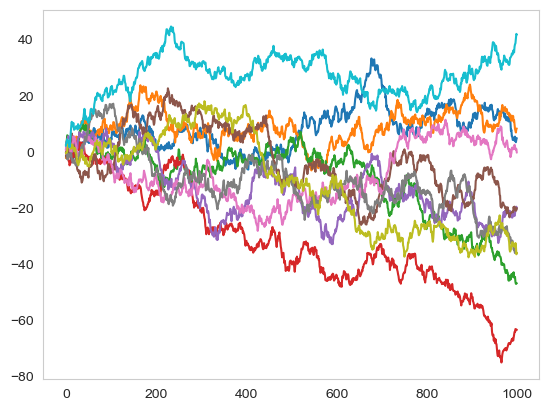

In [30]:
import matplotlib.pyplot as plt

plt.plot(rnmat_1.cumsum(axis = 0))
plt.grid(False)
plt.show()

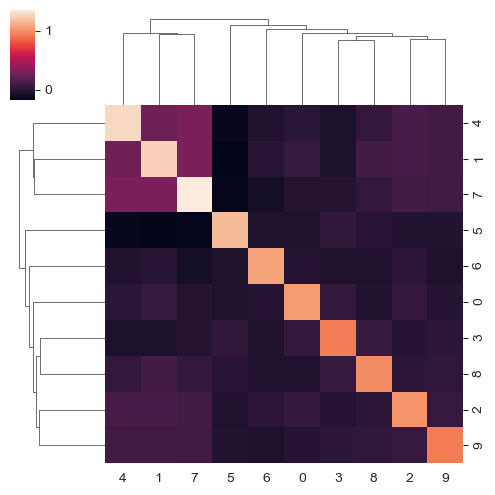

In [40]:
import seaborn as sns
sns.clustermap(np.cov(rnmat_1, rowvar = False), figsize = (5, 5))

In [41]:
rnmat_5 = random_matrix_with_rank(1000, 10, rank = 5, sigma = 1, homNoise = True, random_state = 42)

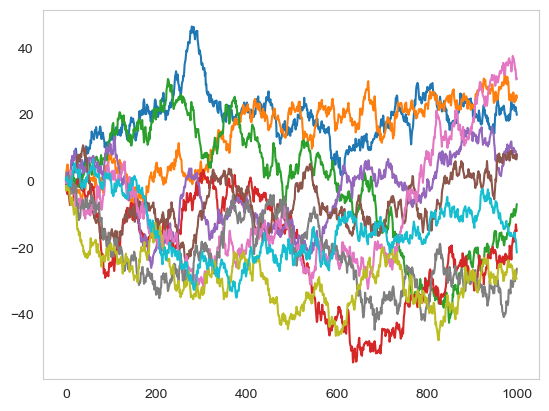

In [42]:
plt.plot(rnmat_5.cumsum(axis = 0))
plt.grid(False)
plt.show()

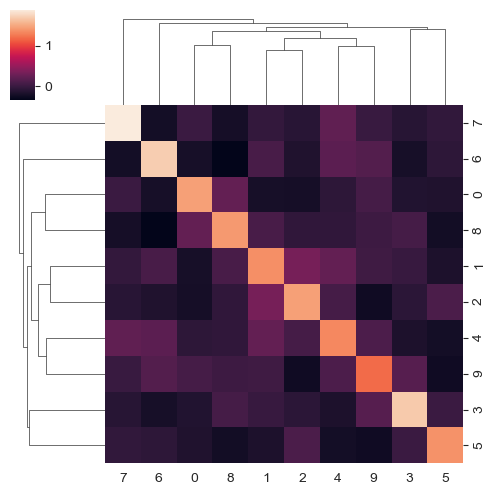

In [43]:
sns.clustermap(np.cov(rnmat_5, rowvar = False), figsize = (5, 5))

In [44]:
rnmat_10 = random_matrix_with_rank(1000, 10, rank = 10, sigma = 1, homNoise = True, random_state = 42)

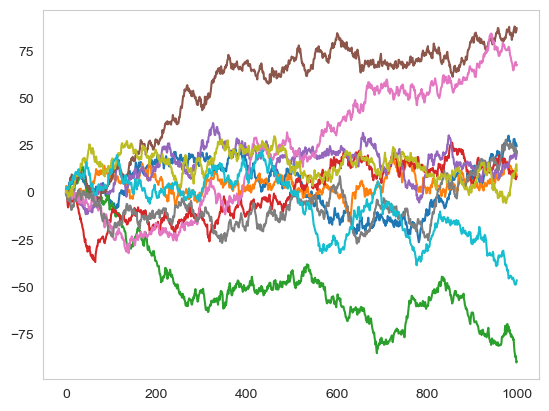

In [46]:
plt.plot(rnmat_10.cumsum(axis = 0))
plt.grid(False)
plt.show()

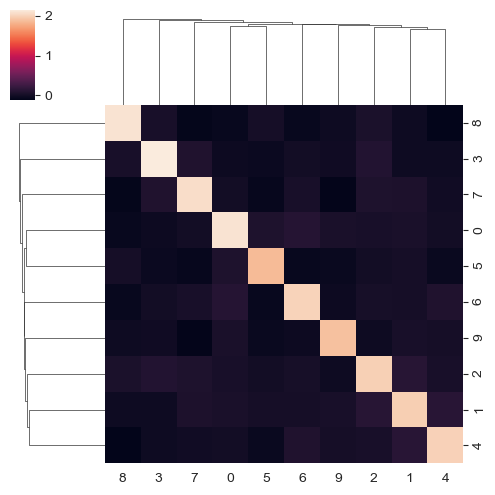

In [47]:
sns.clustermap(np.cov(rnmat_10, rowvar = False), figsize = (5, 5))

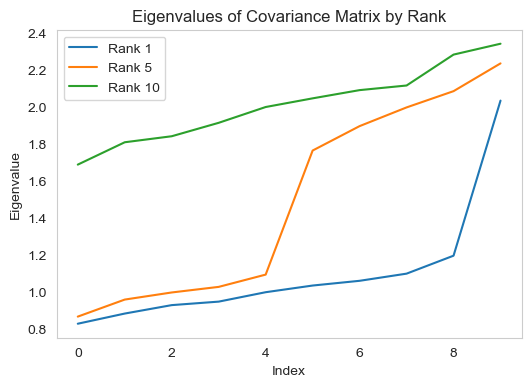

In [52]:
ranks = [1, 5, 10]
n_samples, n_cols = 1000, 10
eigenvalues = {}

for rank in ranks:
    data = random_matrix_with_rank(n_samples, n_cols, rank, sigma=1, homNoise=True, random_state=42)
    cov_matrix = np.cov(data.T)
    eigvals = np.linalg.eigvalsh(cov_matrix)
    eigenvalues[rank] = eigvals

plt.figure(figsize = (6, 4))
for rank, eigvals in eigenvalues.items():
    plt.plot(eigvals, label=f'Rank {rank}')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Covariance Matrix by Rank')
plt.legend()
plt.grid(False)
plt.show()